# Ridge

Following [the documentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html), it performs a regression trying to minimize the sum of squared error (as the linear regression from the previous notebook does) with a **penalty on the size of the coefficients**. Therefore, it tries to minimize the following quantity
$$ ||y - Xw||^2_2 + \alpha  ||w||^2_2 , $$ 
where $w$ is the coefficient vector and the parameter $\alpha$ controls the amount of **regularization** (called $L_2$ as it uses the $L_2$ norm of the coefficient vector). The higher this parameter, the lower will be the variance of the model.

It is a very useful regularization in the case of multicollinearity in the input data that typically lead to very large coefficients. The regularization is putting a penalty on larger coefficients, thus **reducing the effect of multicollinearity**.

On the contrary to the simple linear regression, we have some hyperparameters to play with

In [1]:
import pandas as pd
import numpy as np

import random

import source.hyperplots as hyp
import source.explore as exp
from source.report import plot_predictions, make_results, store_results
from source.utility import cv_score, grid_search
import source.transf_univ as df_p
from source.experiments import make_exp, learning_curve, import_hp, hp_model, grid_results

from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge, Lasso, ElasticNet, SGDRegressor, BayesianRidge, Perceptron

%matplotlib inline
pd.set_option('max_columns', 500)

lab_book = 'data/02_linear_models.csv'  # for storing results
modelname='Ridge'

In [2]:
Ridge()

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

* **alpha**: the regularization and most important hyperparameter to tune. It must be positive. When set to 0, we get the simple Linear regression.
* **copy_X**: that does not affect the results of the model but, if False, may lead to overwriting the input data
* **fit_intercept**: whether or not using an intercept term, not relevant for our cases as we, rightfully, always scale and center our data
* **max_iter**: a parameter that controls the maximum number of iterations the solver can take to converge. Very rarely it needs to be increased and, if so, we might need to consider a different approach
* **normalize**: whether or not normalizing the data and it is ignored if set to False. If True, it uses the StandardScaler we already have in our pipeline
* **random_state**: relevant only for one of the solver since it is stochastic (the 'sag' solver)
* **solver**: the type of solver. Almost always leaving to `auto` is a good move as it will pick the best one for the data provided. The choice will influence the speed and behavior in particular situations.
* **tol**: the precision of the solution

We will play around with some of these hyperparameters to better understand what is their role.

# Noise and correlation

We can now repeat the previous experiments and observe how the algorithm is behaving differently even in the simplest case.

In [3]:
model = Pipeline([('imputer', df_p.df_imputer()), # everything assumes a 2 steps pipeline
                  ('ridge', Ridge())])
params = {'alpha': 1}

kfolds = KFold(10, shuffle=True, random_state=541)

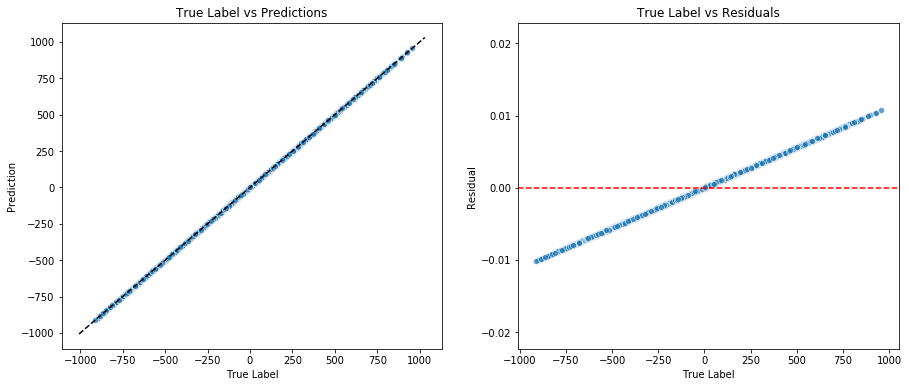

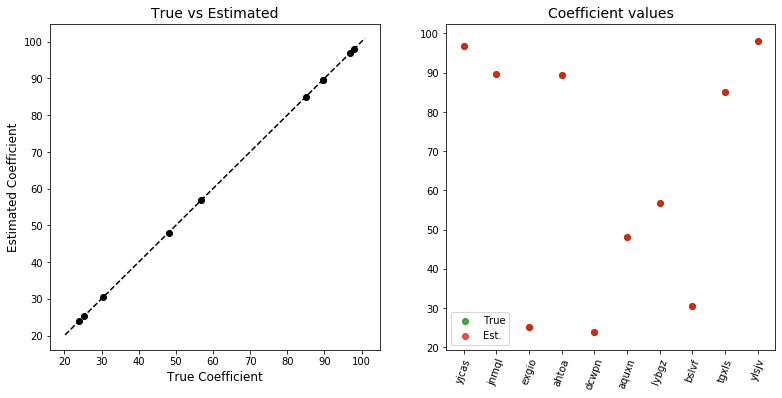

MAE: 		 0.00198
MSE: 		 1e-05
Max Error: 	 0.0107
Expl Variance: 	 1.0


In [4]:
make_exp(model=model, kfolds=kfolds, 
         data_name='data/simulated/10_feat_10_inf_nonoise.csv', 
         target_name=None, 
         features='all',
         sample=False, 
         store=True, coefs=True, store_name=lab_book, parameters=params, model_name=modelname)

While the coefficients are again estimated perfectly, the residuals show a pattern that suggests that the model is having more and more troubles in predicting larger (in the absolute sense) values of the target variable.

On the other hand, the predictions in the presence of noise and/or correlation are nearly identical

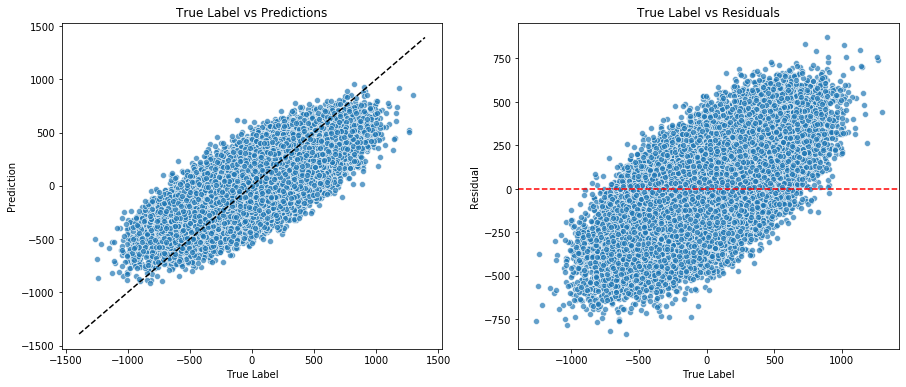

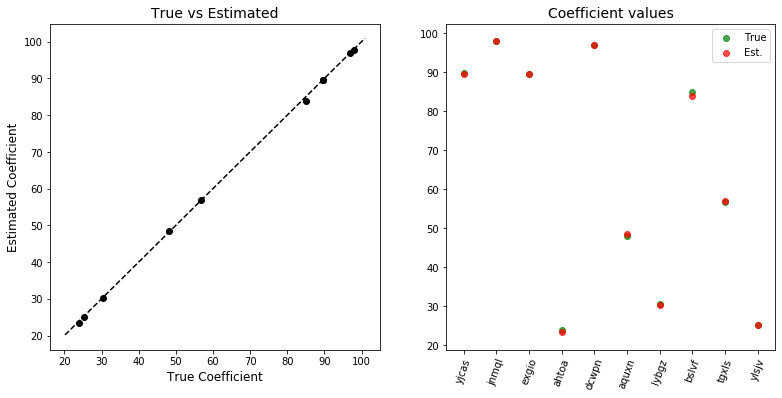

MAE: 		 159.15957
MSE: 		 39903.46366
Max Error: 	 870.78567
Expl Variance: 	 0.55337


In [5]:
make_exp(model=model, kfolds=kfolds, 
         data_name='data/simulated/10_feat_10_inf_noise.csv', 
         target_name=None, 
         features='all',
         sample=False, 
         store=True, coefs=True, store_name=lab_book, parameters=params, model_name=modelname)

Which is precisely the same result we got without the regularization

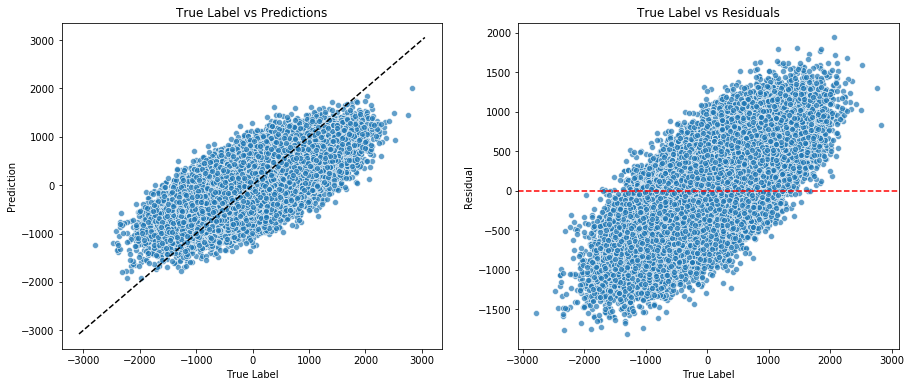

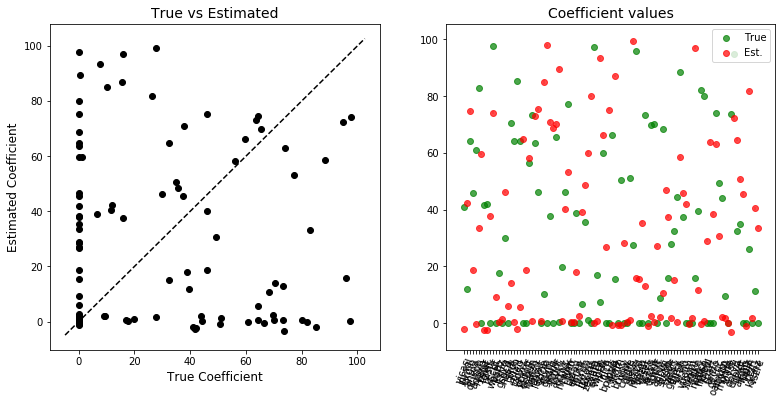

MAE: 		 359.51791
MSE: 		 202633.43736
Max Error: 	 1939.61387
Expl Variance: 	 0.48907


In [6]:
make_exp(model=model, kfolds=kfolds, 
         data_name='data/simulated/100_feat_65_inf_noise.csv', 
         target_name=None, 
         features='all',
         sample=False, 
         store=True, coefs=True, store_name=lab_book, parameters=params, model_name=modelname)

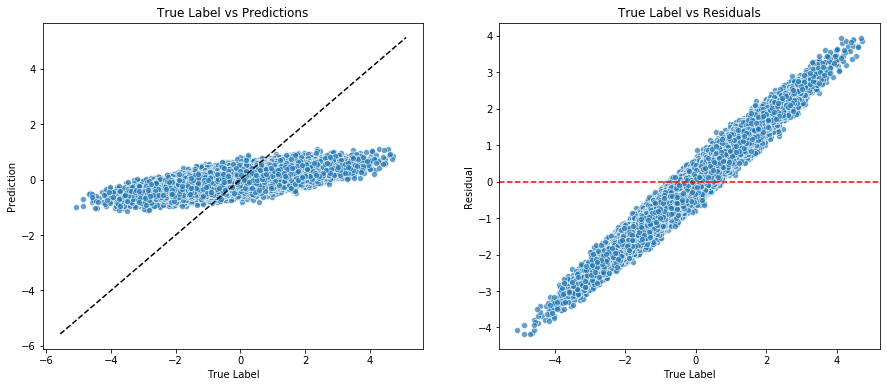

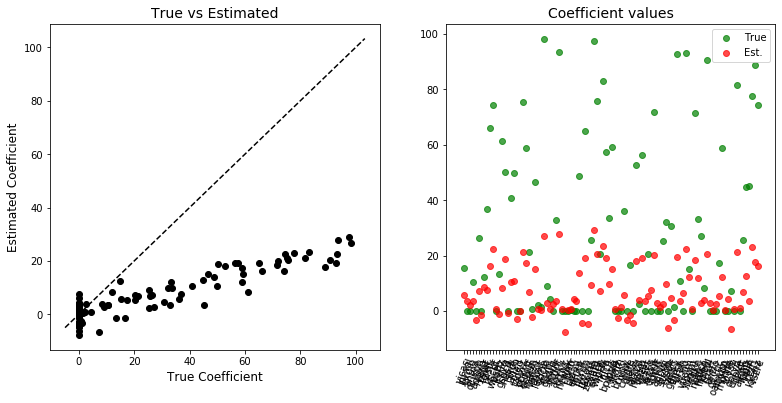

MAE: 		 0.79954
MSE: 		 1.00325
Max Error: 	 4.16769
Expl Variance: 	 0.26507


In [7]:
make_exp(model=model, kfolds=kfolds, 
         data_name='data/simulated/100_feat_65_inf_noise_rank.csv', 
         target_name=None, 
         features='all',
         sample=False, 
         store=True, coefs=True, store_name=lab_book, parameters=params, model_name=modelname)

# Number of instances

The behavior is not changing much when we introduce the regularization. However, the solver is now chosen automatically given the features and this leads to faster training time. The training time still grows linearly, but with a lower rate of increase.

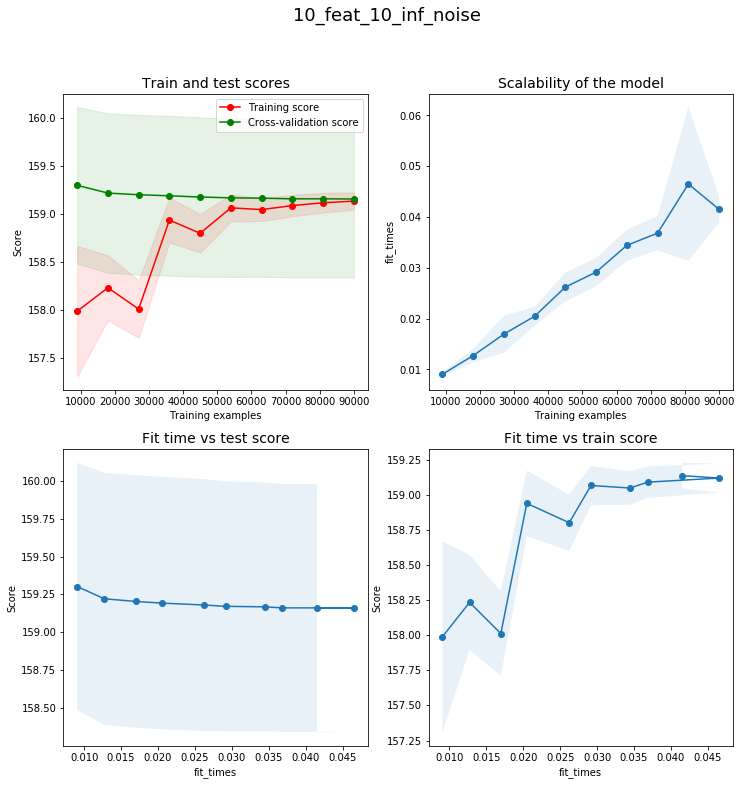

In [8]:
learning_curve(model=model, data_name='data/simulated/10_feat_10_inf_noise.csv', kfolds=kfolds)

For comparison, on the next set of data the fit time was going as high as 3 seconds, while now it is around 0.5 seconds.

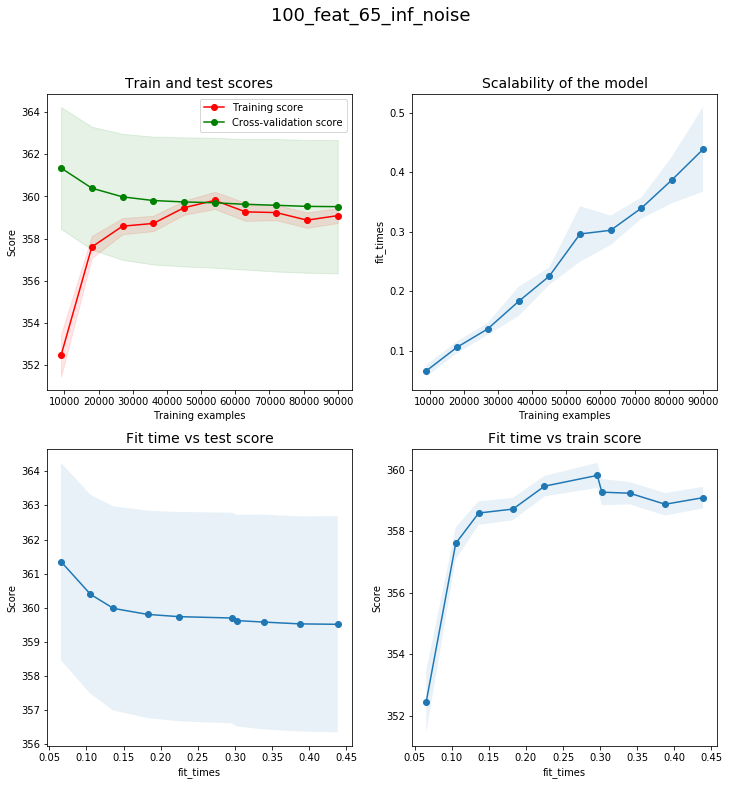

In [9]:
learning_curve(model=model, data_name='data/simulated/100_feat_65_inf_noise.csv', kfolds=kfolds)

It is important to keep in mind that the higher speed has nothing to do with the regularization introduced but rather with **a better implementation of the algorithm**. Therefore, if you ever need a faster version of `LinearRegression`, you could rely on `Ridge(alpha=0)`.


By reducing the number of training instances, we observe a less accurate set of predictions but still a good estimate of the coefficients

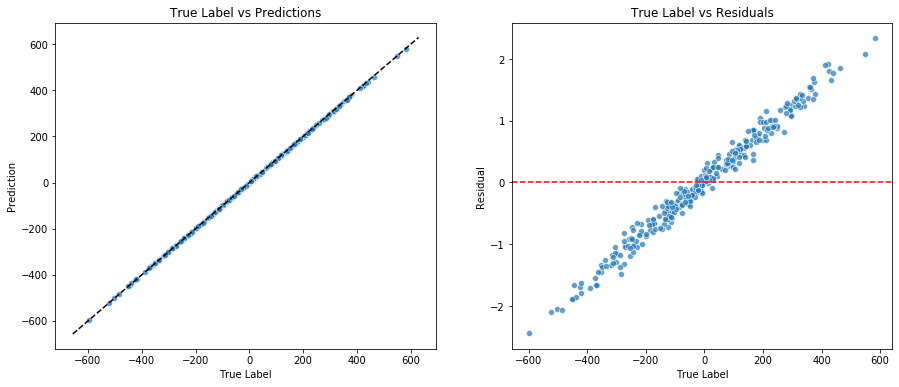

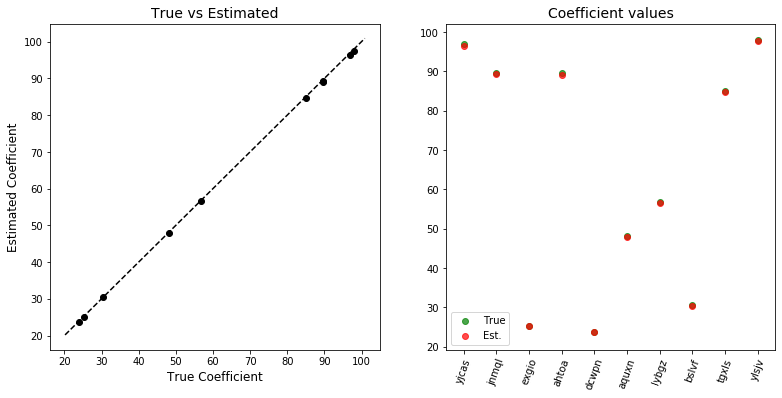

MAE: 		 0.72089
MSE: 		 0.79516
Max Error: 	 2.44387
Expl Variance: 	 0.99998


In [10]:
make_exp(model=model, kfolds=kfolds, 
         data_name='data/simulated/10_feat_10_inf_nonoise.csv', 
         target_name=None, 
         features='all',
         sample=300, 
         store=True, coefs=True, store_name=lab_book, parameters=params, model_name=modelname)

It is worth noticing that, with this set of data of the next, the regularization is bringing to generally worse predictions in terms of mean absolute error and explained variance, but better results in terms of mean squared error and max error. Moreover, the estimates of the coefficients are arguably closer to their true values and we can give the merit to the regularizing term in the loss function.

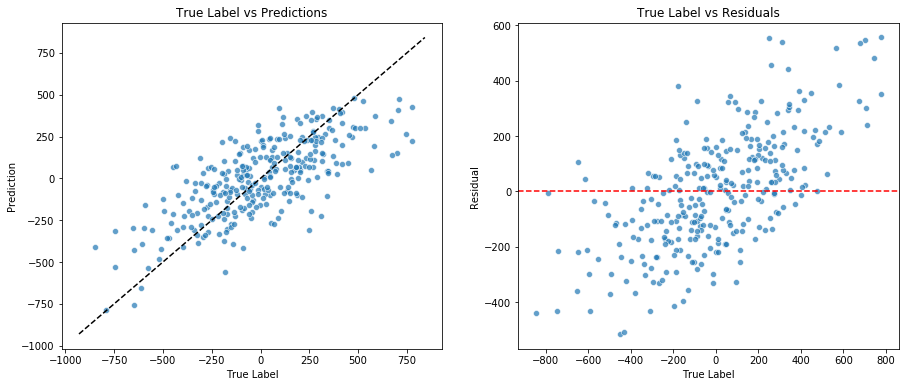

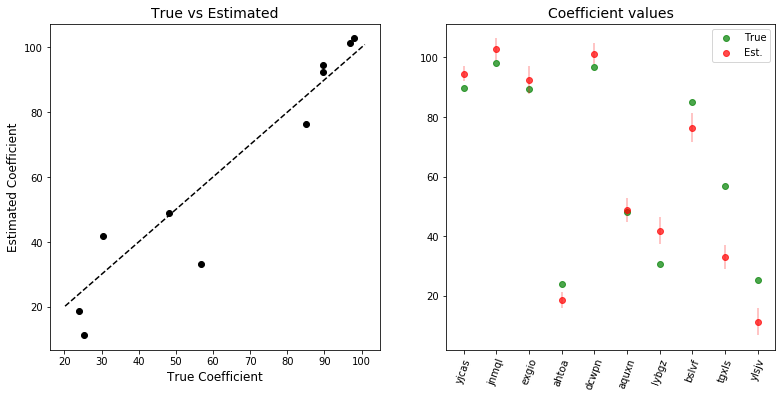

MAE: 		 162.68496
MSE: 		 41894.09877
Max Error: 	 555.69497
Expl Variance: 	 0.53754


In [11]:
make_exp(model=model, kfolds=kfolds, 
         data_name='data/simulated/10_feat_10_inf_noise.csv', 
         target_name=None, 
         features='all',
         sample=300, 
         store=True, coefs=True, store_name=lab_book, parameters=params, model_name=modelname)

# More complex data

To observe more meaningful patterns, we turn out attention to a dataset with more complex relations.

## 100 features

As in the previous examples, the speed of the model is much higher (thanks to the better implementation) and we can again observe that the regularizing term is not influencing the ability of the model to be close to the best achievable result already with 9000 training samples.

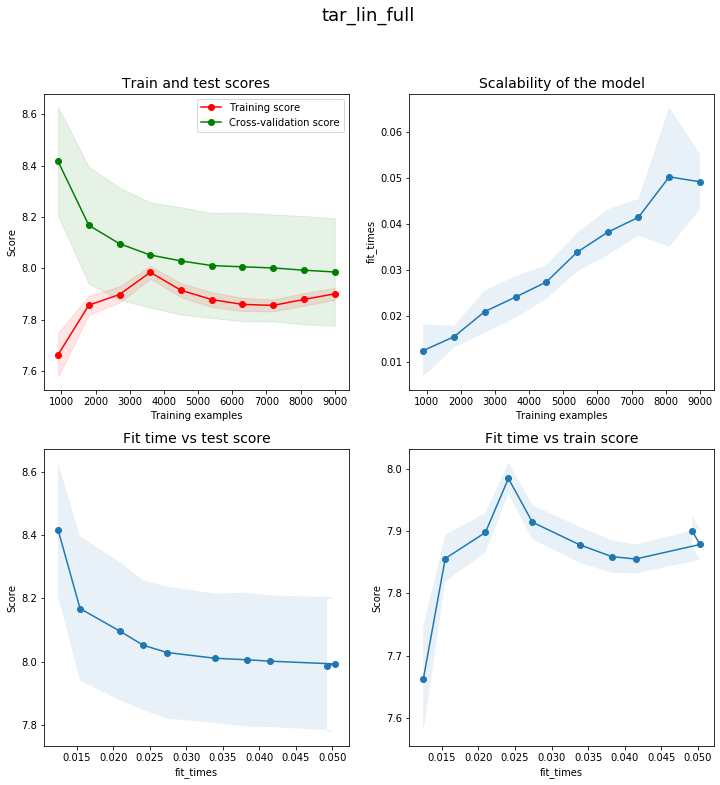

In [12]:
learning_curve(model, target_name='tar_lin_full', features='all', sample=10000, kfolds=kfolds)

When using all the features, we have seen in the previous notebook that the model was generally underestimating the coefficients, a pattern that is not as evident now with the regularizing term.

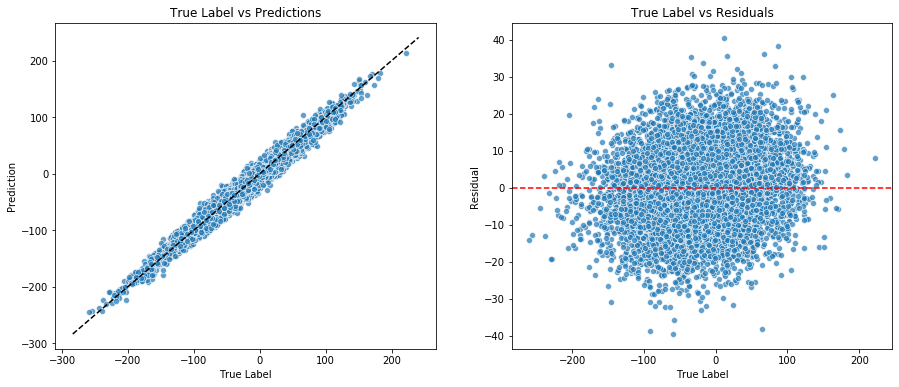

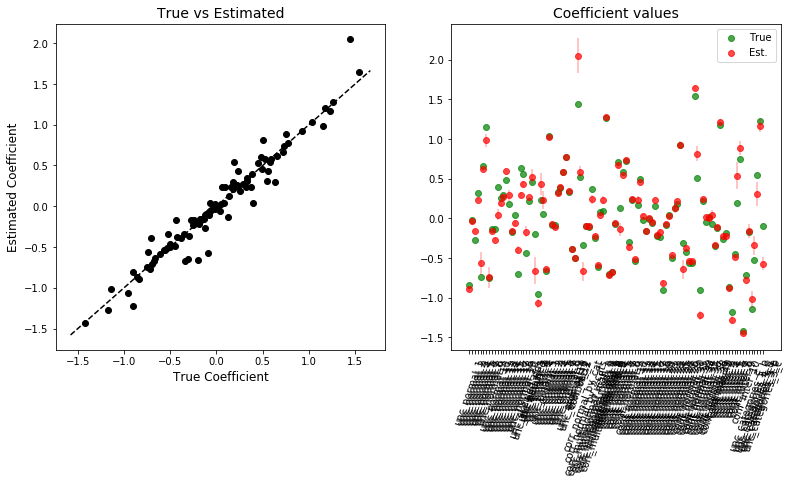

MAE: 		 8.01595
MSE: 		 101.27984
Max Error: 	 40.63641
Expl Variance: 	 0.9706


In [13]:
make_exp(model=model, kfolds=kfolds, 
         data_name=None, 
         target_name='tar_lin_full', 
         features='all',
         sample=10000, 
         store=True, coefs=True, store_name=lab_book, parameters=params, model_name=modelname)

However, we can't help but notice that the model is not performing better than before.

On the other hand, when reducing the number of features the drop in performance is much smaller than before.

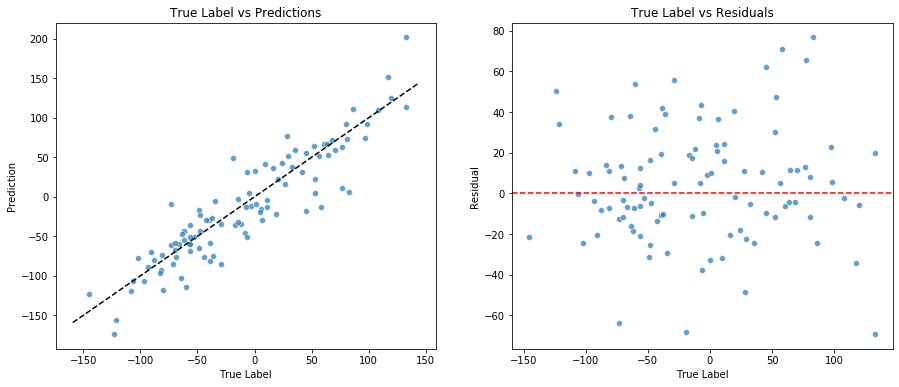

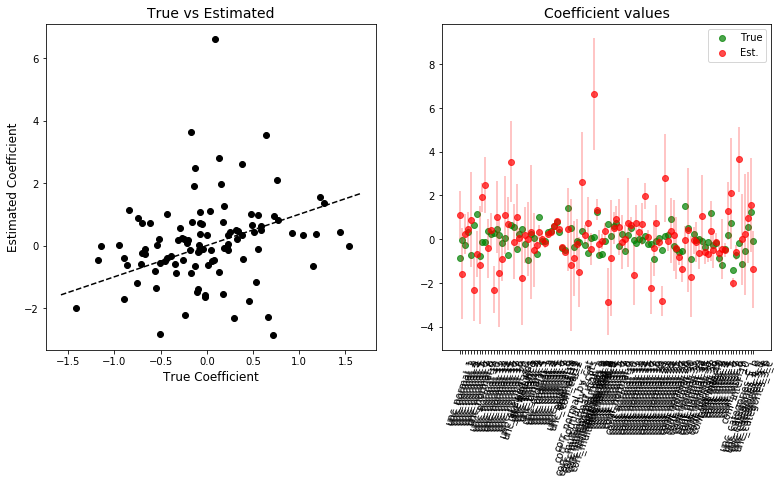

MAE: 		 22.0322
MSE: 		 817.20173
Max Error: 	 76.71232
Expl Variance: 	 0.80809


In [14]:
make_exp(model=model, kfolds=kfolds, 
         data_name=None, 
         target_name='tar_lin_full', 
         features='all',
         sample=100, 
         store=True, coefs=True, store_name=lab_book, parameters=params, model_name=modelname)

In the presence of **unobserved variables**, however, the model struggles and start to present some large errors in the cefficients' estimates.

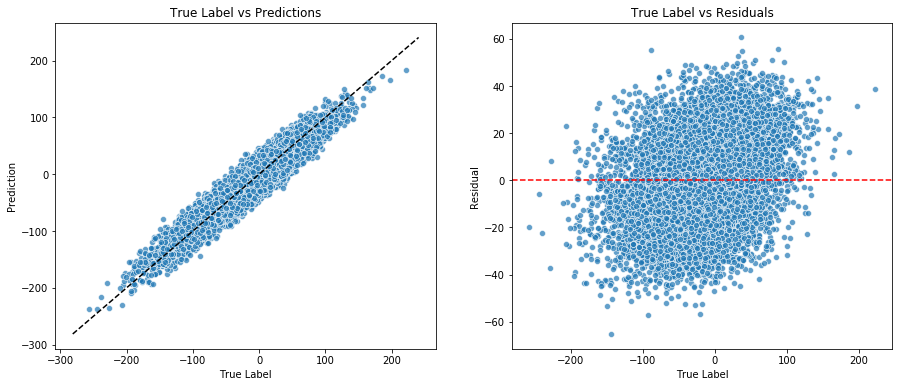

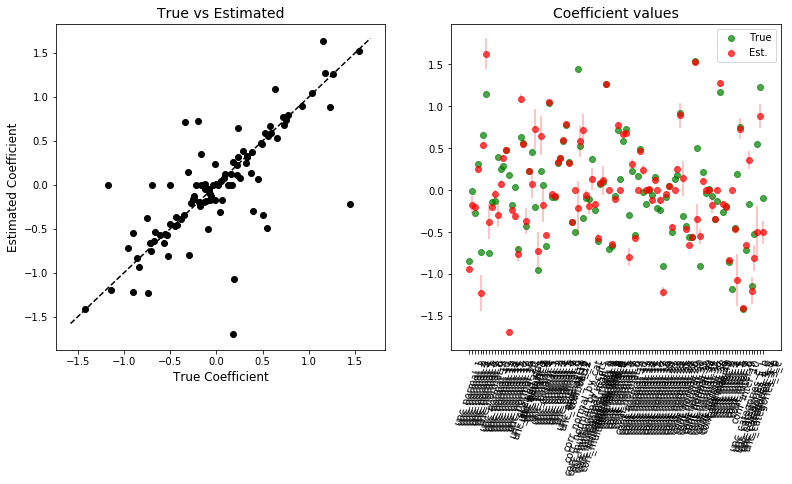

MAE: 		 15.80464
MSE: 		 366.32241
Max Error: 	 65.20255
Expl Variance: 	 0.88725


In [15]:
make_exp(model=model, kfolds=kfolds, 
         data_name=None, 
         target_name='tar_lin_full', 
         features='unobserved',
         sample=10000, 
         store=True, coefs=True, store_name=lab_book, parameters=params, model_name=modelname)

## 50 features

Let's now turn our attention to a situation where only 50 features of the 100 available have been used to generate the target

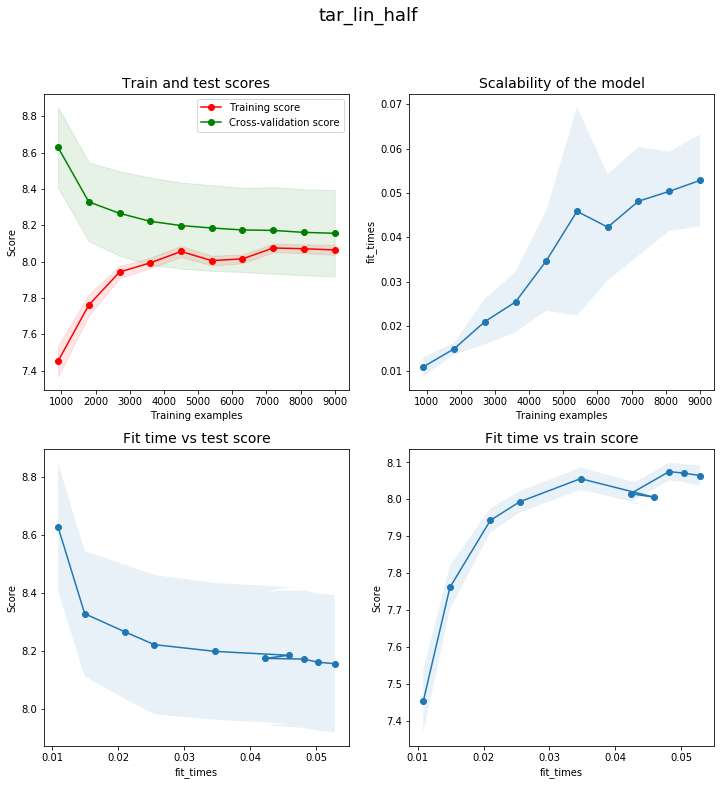

In [16]:
learning_curve(model, target_name='tar_lin_half', features='all', sample=10000, kfolds=kfolds)

We can also appreciate how faster and more accurate the model becomes when we use the exact features we need to predict the target

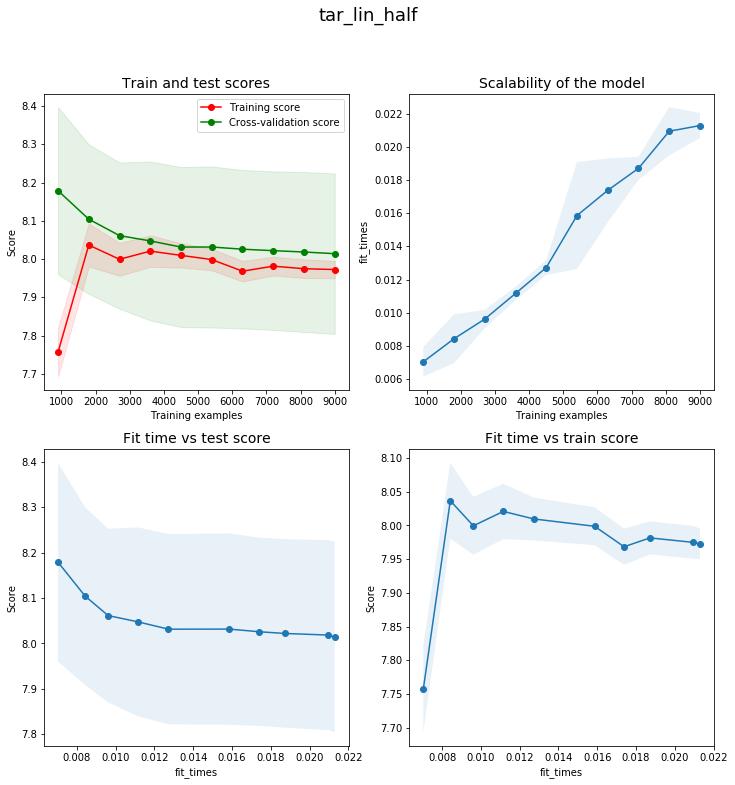

In [17]:
learning_curve(model, target_name='tar_lin_half', features='exact', sample=10000, kfolds=kfolds)

We can thus use this as baseline for the next set of experiments. The performance is nearly identical with or without the regularization

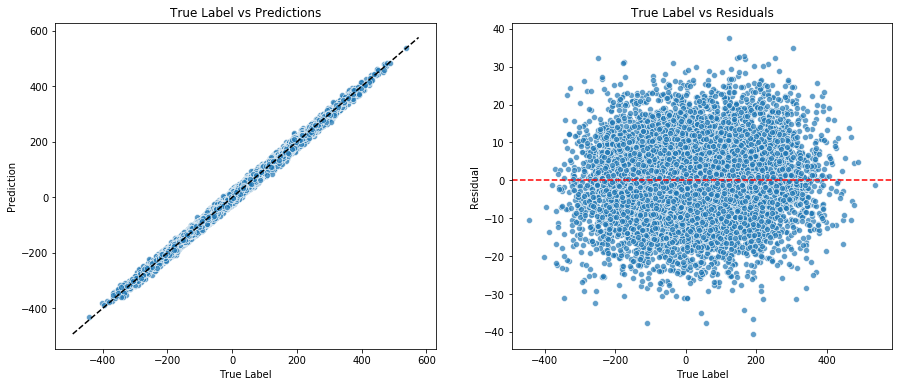

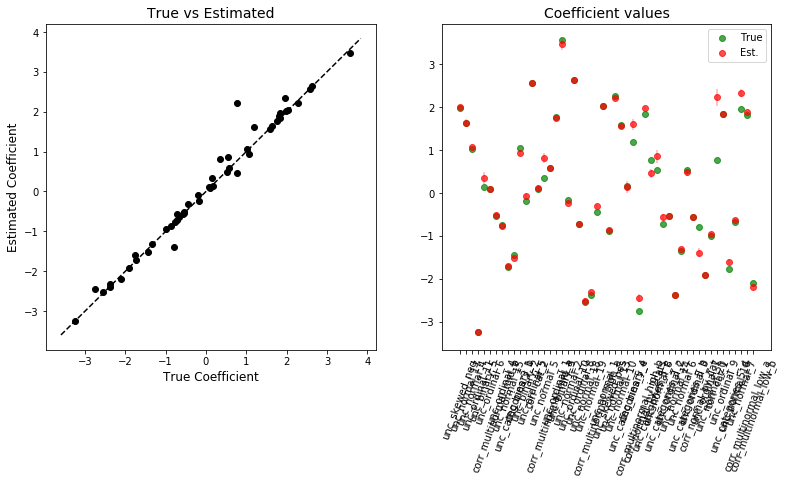

MAE: 		 7.97518
MSE: 		 100.64482
Max Error: 	 40.54856
Expl Variance: 	 0.99547


In [18]:
make_exp(model=model, kfolds=kfolds, 
         data_name=None, 
         target_name='tar_lin_half', 
         features='exact',
         sample=10000, 
         store=True, coefs=True, store_name=lab_book, parameters=params, model_name=modelname)

Predictably, reducing the number of training instances leads to a worse performing model but, this time, it is performing better than its non-regularized counterpart

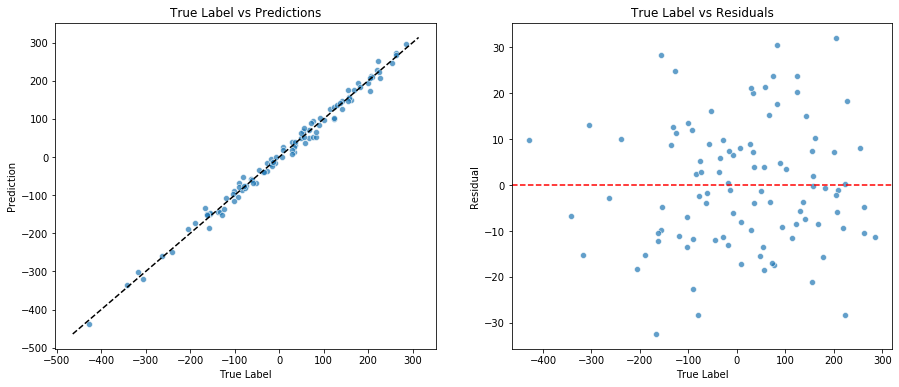

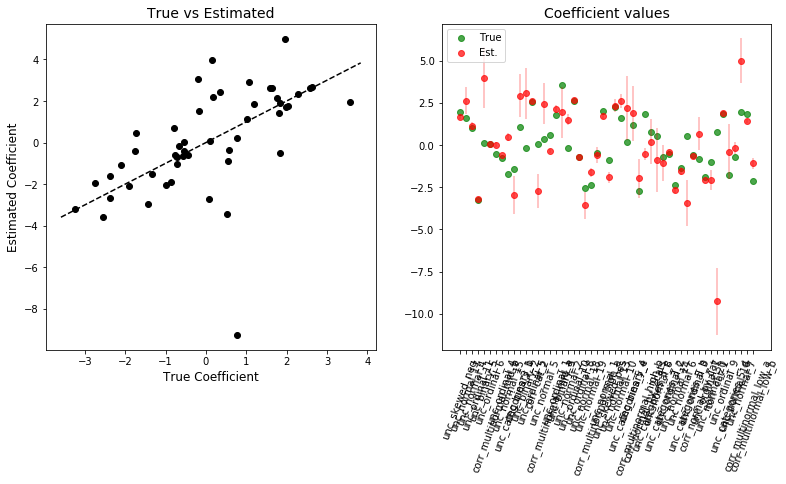

MAE: 		 11.11508
MSE: 		 183.26299
Max Error: 	 32.41328
Expl Variance: 	 0.99151


In [19]:
make_exp(model=model, kfolds=kfolds, 
         data_name=None, 
         target_name='tar_lin_half', 
         features='exact',
         sample=100, 
         store=True, coefs=True, store_name=lab_book, parameters=params, model_name=modelname)

Training the model on more features than necessary doesn't seem to influence the performance or the coefficients' estimates much.

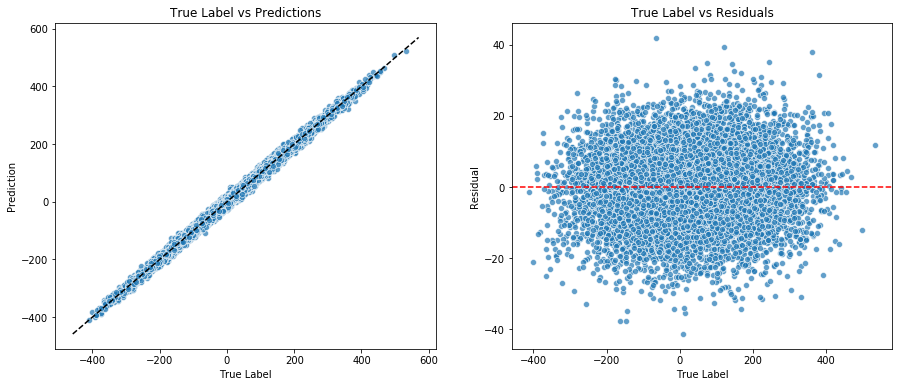

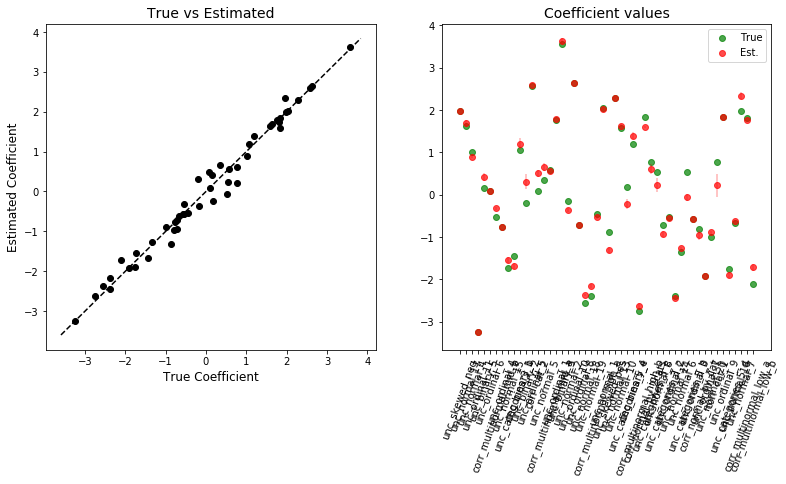

MAE: 		 8.06455
MSE: 		 103.07685
Max Error: 	 42.06058
Expl Variance: 	 0.99536


In [21]:
make_exp(model=model, kfolds=kfolds, 
         data_name=None, 
         target_name='tar_lin_half', 
         features='all',
         sample=10000, 
         store=True, coefs=True, store_name=lab_book, parameters=params, model_name=modelname)

But again the drop in performance that one expects when the number of training instances is reduced is somewhat smaller thanks to the regularization. The reason is that the model is not giving too much importance to one feature due to the limited sample thanks to the fact that the magnitude of the coefficients is regularized by the term *alpha*.

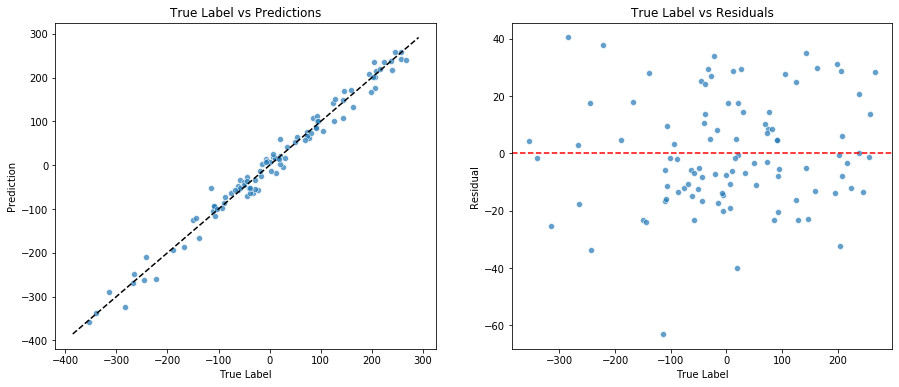

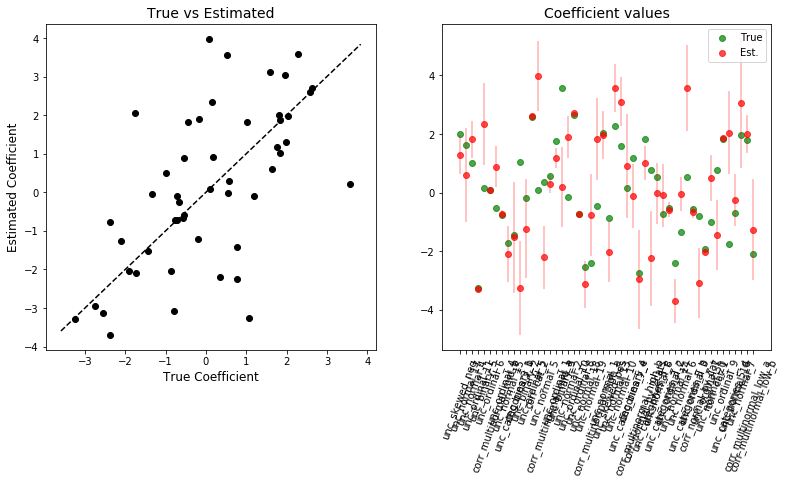

MAE: 		 15.38071
MSE: 		 362.86508
Max Error: 	 63.0006
Expl Variance: 	 0.98215


In [22]:
make_exp(model=model, kfolds=kfolds, 
         data_name=None, 
         target_name='tar_lin_half', 
         features='all',
         sample=100, 
         store=True, coefs=True, store_name=lab_book, parameters=params, model_name=modelname)

On the other hand, when it is a certain number of features missing, the regularization does not seem to help much.

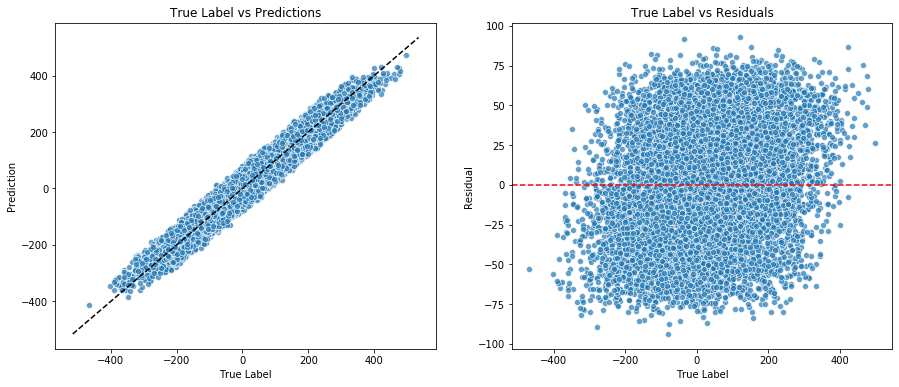

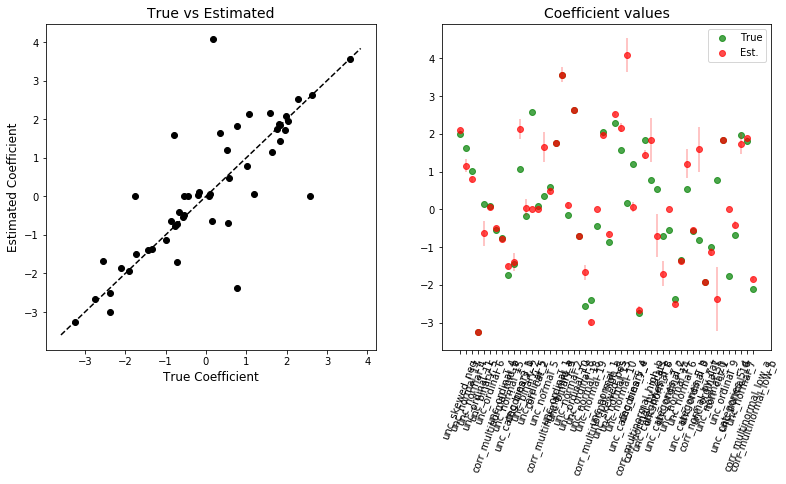

MAE: 		 32.08188
MSE: 		 1416.67493
Max Error: 	 93.87125
Expl Variance: 	 0.93488


In [23]:
make_exp(model=model, kfolds=kfolds, 
         data_name=None, 
         target_name='tar_lin_half', 
         features='exact-10',
         sample=10000, 
         store=True, coefs=True, store_name=lab_book, parameters=params, model_name=modelname)

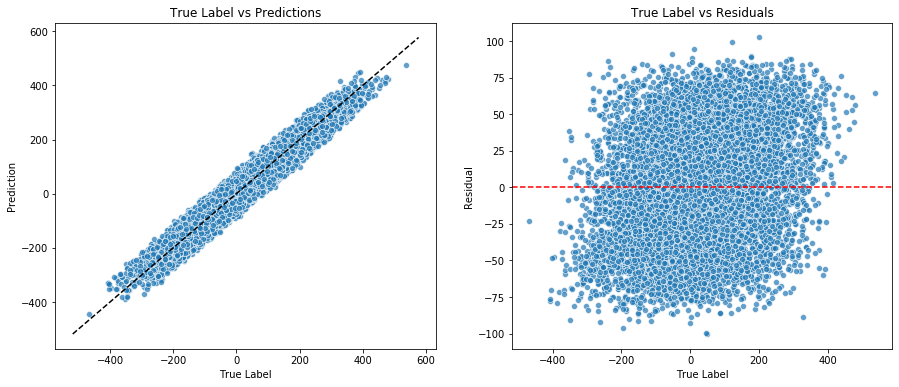

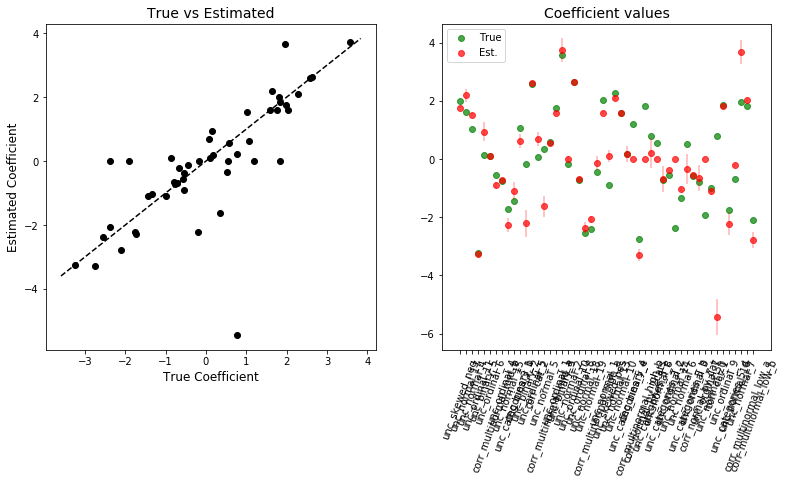

MAE: 		 34.2441
MSE: 		 1609.95082
Max Error: 	 102.3838
Expl Variance: 	 0.92673


In [24]:
make_exp(model=model, kfolds=kfolds, 
         data_name=None, 
         target_name='tar_lin_half', 
         features='unobserved',
         sample=10000, 
         store=True, coefs=True, store_name=lab_book, parameters=params, model_name=modelname)

## 10 features

We have already seen how easy it is for the model to pick up the signal from the data. Introducing a regularization term is helping in slighly improving the metrics.

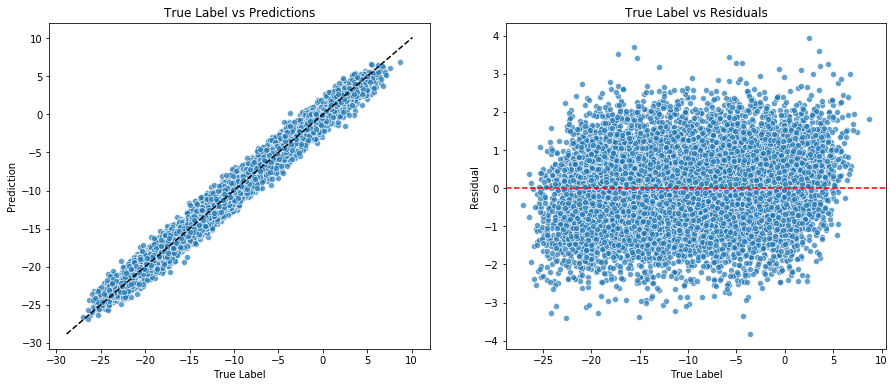

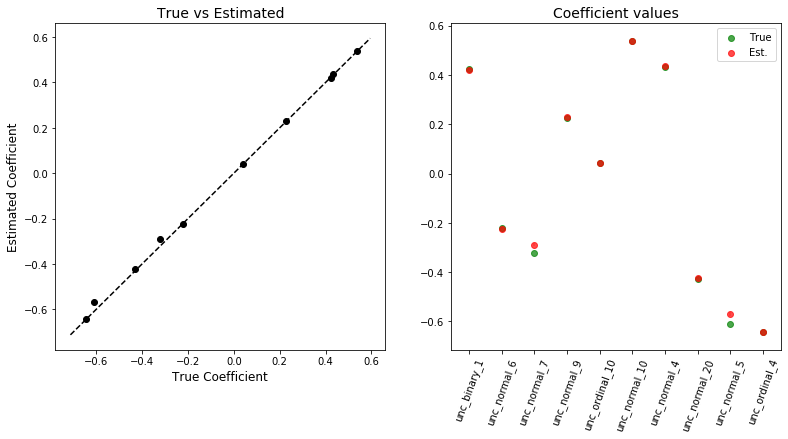

MAE: 		 0.79759
MSE: 		 0.99747
Max Error: 	 3.94244
Expl Variance: 	 0.98268


In [25]:
make_exp(model=model, kfolds=kfolds, 
         data_name=None, 
         target_name='tar_lin_10', 
         features='exact',
         sample=10000, 
         store=True, coefs=True, store_name=lab_book, parameters=params, model_name=modelname)

We can also see how the performance gets worse if we reduce the training instances to 100. In particular, we see 2 coefficients wrongly estimated quite significantly.

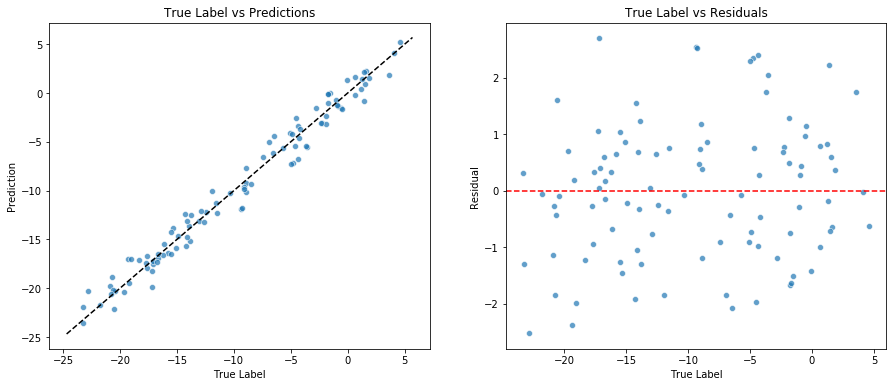

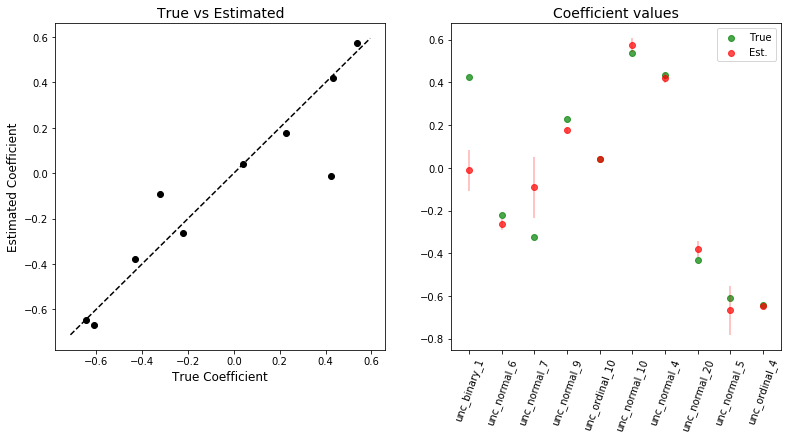

MAE: 		 0.98542
MSE: 		 1.46595
Max Error: 	 2.70081
Expl Variance: 	 0.97535


In [26]:
make_exp(model=model, kfolds=kfolds, 
         data_name=None, 
         target_name='tar_lin_10', 
         features='exact',
         sample=100, 
         store=True, coefs=True, store_name=lab_book, parameters=params, model_name=modelname)

On the other hand, using more features or fewer features than necessary doesn't seem to compromise the model behavior much.

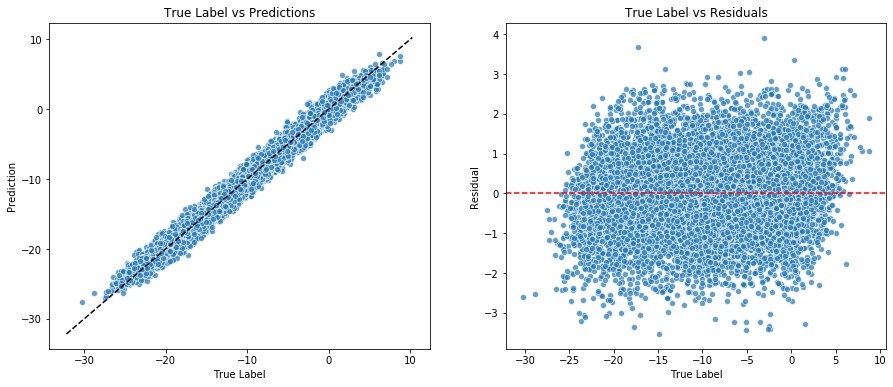

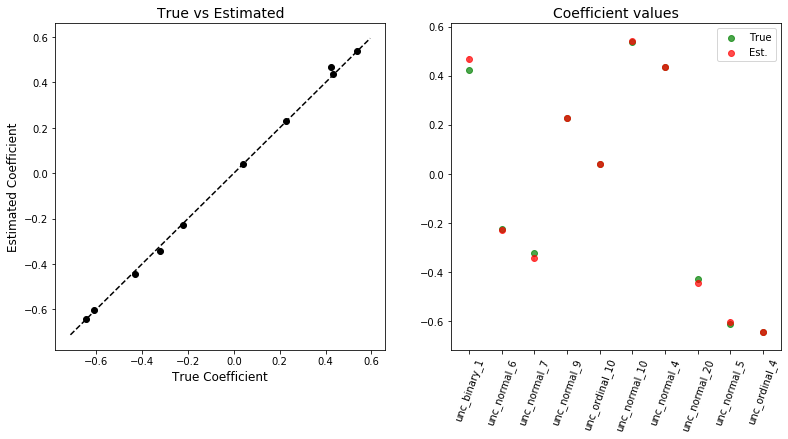

MAE: 		 0.80267
MSE: 		 1.01295
Max Error: 	 3.91334
Expl Variance: 	 0.98216


In [27]:
make_exp(model=model, kfolds=kfolds, 
         data_name=None, 
         target_name='tar_lin_10', 
         features='all',
         sample=10000, 
         store=True, coefs=True, store_name=lab_book, parameters=params, model_name=modelname)

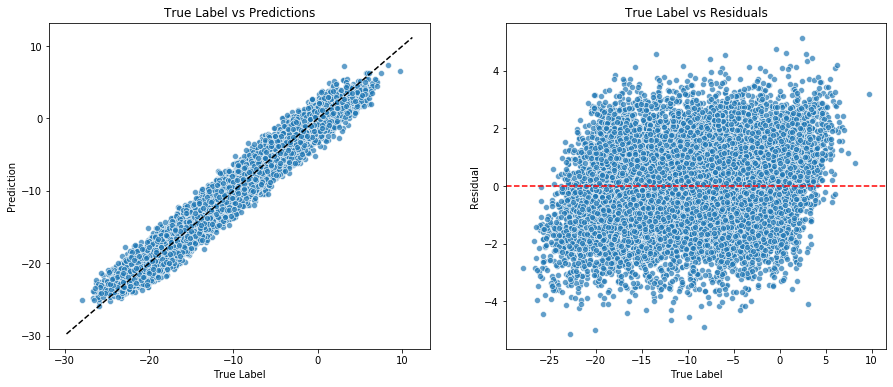

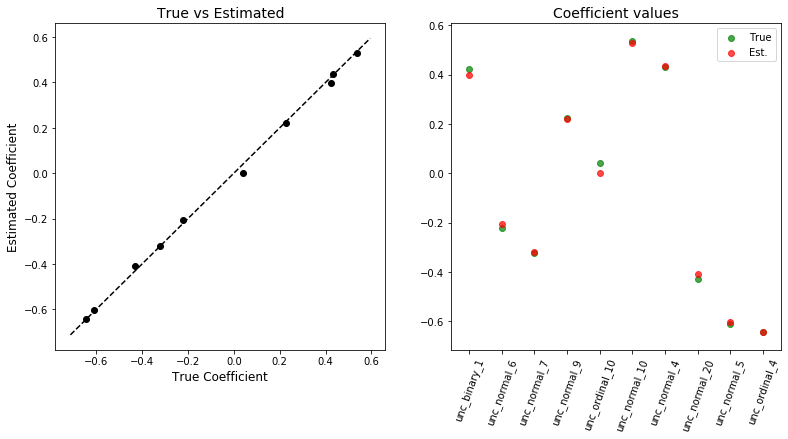

MAE: 		 1.26746
MSE: 		 2.40104
Max Error: 	 5.14349
Expl Variance: 	 0.95686


In [28]:
make_exp(model=model, kfolds=kfolds, 
         data_name=None, 
         target_name='tar_lin_10', 
         features='exact-10',
         sample=10000, 
         store=True, coefs=True, store_name=lab_book, parameters=params, model_name=modelname)

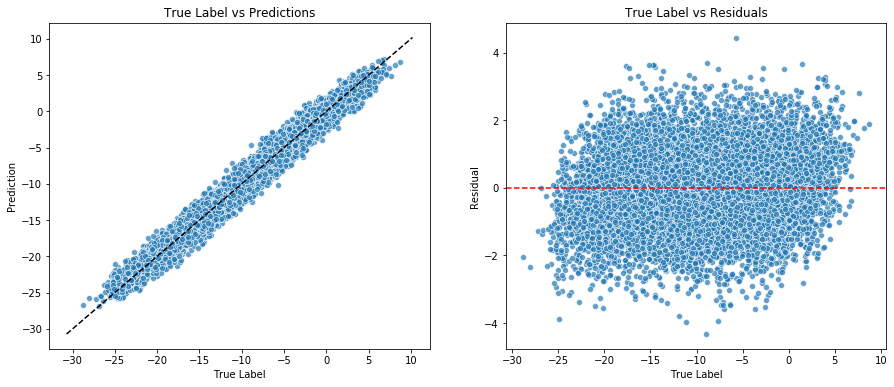

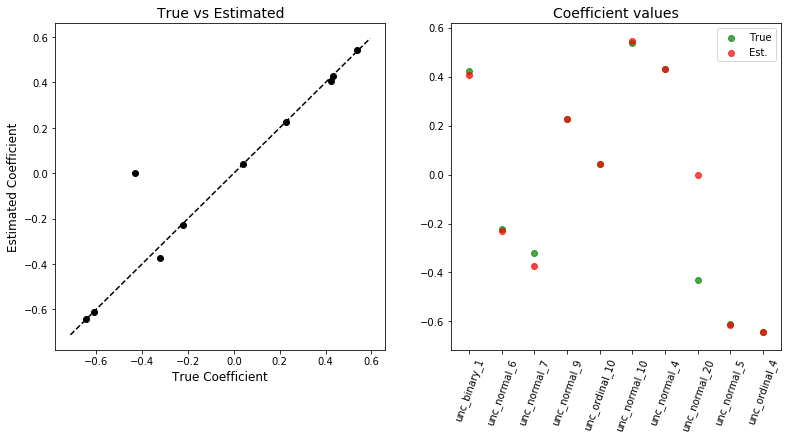

MAE: 		 0.91065
MSE: 		 1.30482
Max Error: 	 4.43846
Expl Variance: 	 0.97733


In [29]:
make_exp(model=model, kfolds=kfolds, 
         data_name=None, 
         target_name='tar_lin_10', 
         features='unobserved',
         sample=10000, 
         store=True, coefs=True, store_name=lab_book, parameters=params, model_name=modelname)

## Non-linear relations

Using a target generated non-linearly we expect

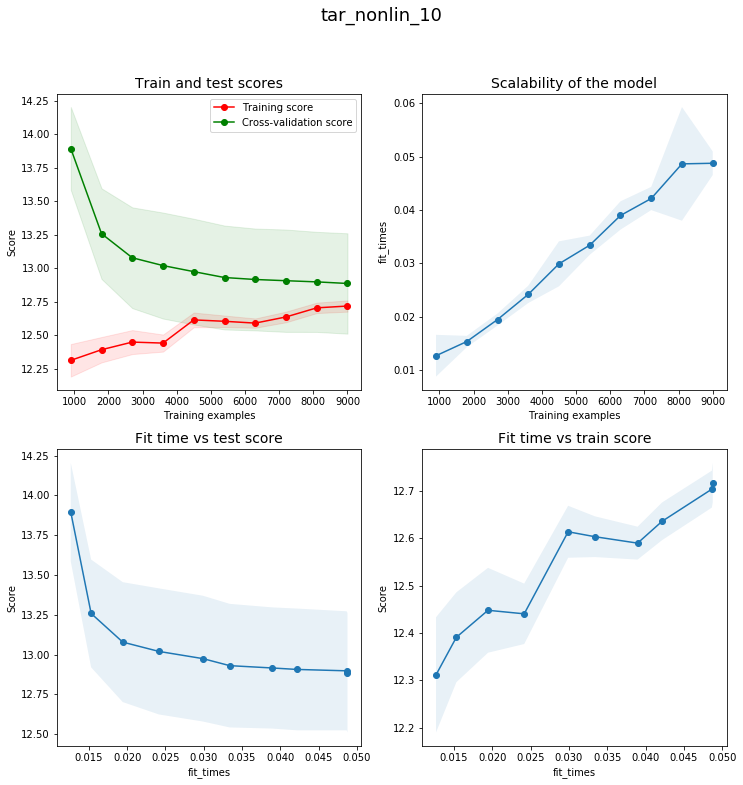

In [30]:
learning_curve(model, target_name='tar_nonlin_10', features='all', sample=10000, kfolds=kfolds)

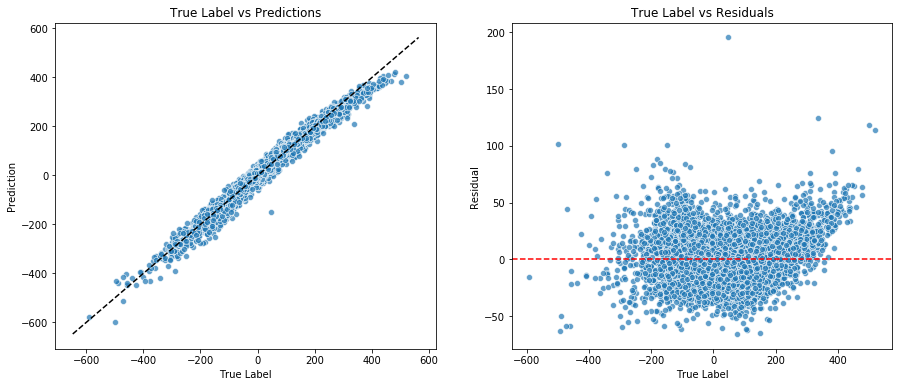

MAE: 		 12.87836
MSE: 		 307.52218
Max Error: 	 195.55884
Expl Variance: 	 0.97915


In [31]:
make_exp(model=model, kfolds=kfolds, 
         data_name=None, 
         target_name='tar_nonlin_10', 
         features='all',
         sample=10000, 
         store=True, coefs=False, store_name=lab_book, parameters=params, model_name=modelname)

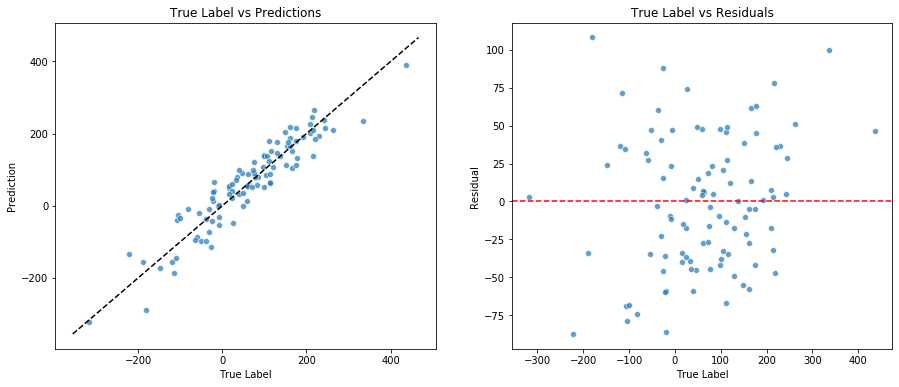

MAE: 		 35.87778
MSE: 		 1881.06525
Max Error: 	 108.00528
Expl Variance: 	 0.87289


In [32]:
make_exp(model=model, kfolds=kfolds, 
         data_name=None, 
         target_name='tar_nonlin_10', 
         features='all',
         sample=100, 
         store=True, coefs=False, store_name=lab_book, parameters=params, model_name=modelname)

## Hyperparameters

All the above experiments were performed using the default hyperparameters, which generally gives a good indication of the model performance to compare results. However, this time we can control more the behavior of the model. This section will do just that.

First, we need to generate the results for different model configurations. We do so by using the custom grid search function imported from the utility module.

We will explore configurations that differ per regularization, precision, and solver type. Due to the need of seeing some pattern, we will use a dataset without noise in order to have errors at an order of magnitude that let us see the variation when the hyperparameter varies. Later, using more complex dataset, we will see more interesting patterns.

Moreover, we noticed already that with enough observations the regularization is not changing the result significantly. We will thus focus on a limited sample size, in the hope this will be enough to draw some conclusions

In [11]:
model = Pipeline([('imputer', df_p.df_imputer()), 
                  ('ridge', Ridge(random_state=325))])

param_grid = {'ridge__alpha': list(np.arange(0, 11, 1)), 
              'ridge__tol': np.arange(0.001, 0.01, 0.001), 
              'ridge__solver': ['svd', 'sparse_cg', 'lsqr', 'saga']}

res = grid_results(model, kfolds, param_grid, data_name='data/simulated/10_feat_10_inf_nonoise.csv', sample=1000)

res.head()

{'ridge__alpha': 0, 'ridge__solver': 'svd', 'ridge__tol': 0.001}


param_ridge__alpha param_ridge__solver param_ridge__tol  mean_train_score  \
0                  0                 svd            0.001     -1.747422e-13   
1                  0                 svd            0.003     -1.747422e-13   
2                  0                 svd            0.004     -1.747422e-13   
3                  0                 svd            0.005     -1.747422e-13   
4                  0                 svd            0.006     -1.747422e-13   

   std_train_score  mean_test_score  std_test_score  mean_fit_time  \
0     6.087456e-14    -1.675639e-13    6.012186e-14       0.003691   
1     6.087456e-14    -1.675639e-13    6.012186e-14       0.003291   
2     6.087456e-14    -1.675639e-13    6.012186e-14       0.003269   
3     6.087456e-14    -1.675639e-13    6.012186e-14       0.004696   
4     6.087456e-14    -1.675639e-13    6.012186e-14       0.004910   

   std_fit_time  mean_score_time  std_score_time  
0      0.000821         0.001400        0.000051  
1      0.000092         0.001345        0.000034  
2      0.000094         0.001346        0.000041  
3      0.004190         0.001357        0.000051  
4      0.005123         0.001625        0.000816

First, we see how the choice of the solver is influencing the training time, with `lsqr` and `sparse_cg` being the fastest. On the other hand, different solvers seem to get different scores but it is worth noticing that, by increasing the regularization, this difference becomes less and less relevant.

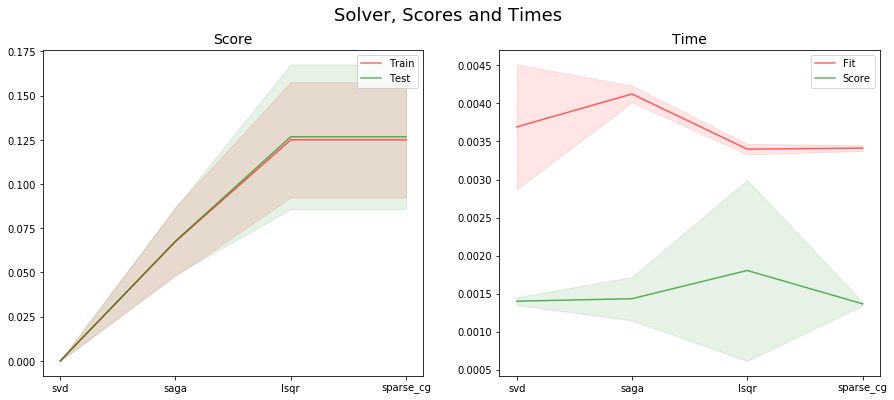

In [12]:
hyp.plot_hyperparameter(res[(res.param_ridge__alpha == 0) & (res.param_ridge__tol==0.001)], 'param_ridge__solver', 'Solver')

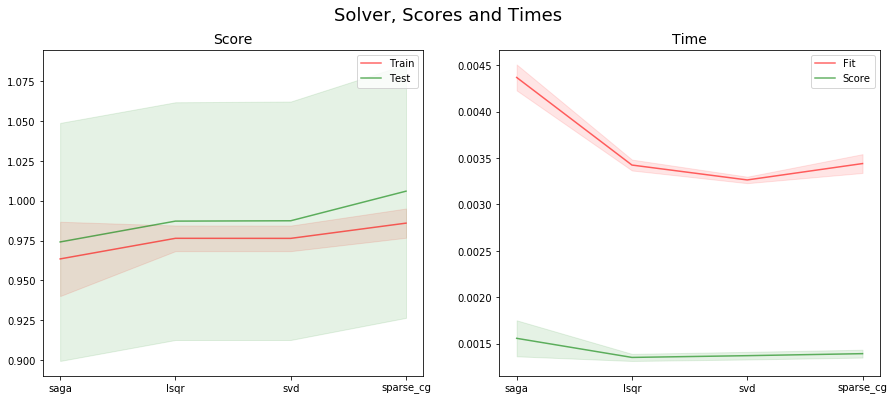

In [13]:
hyp.plot_hyperparameter(res[(res.param_ridge__alpha == 5) & (res.param_ridge__tol==0.001)], 'param_ridge__solver', 'Solver')

This is an artifact of the role of alpha in the model performance, which in this case (a purely linear regression) is getting worse and worse when alpha gets bigger. At the same time, we also notice that this choice does not influence the training time.

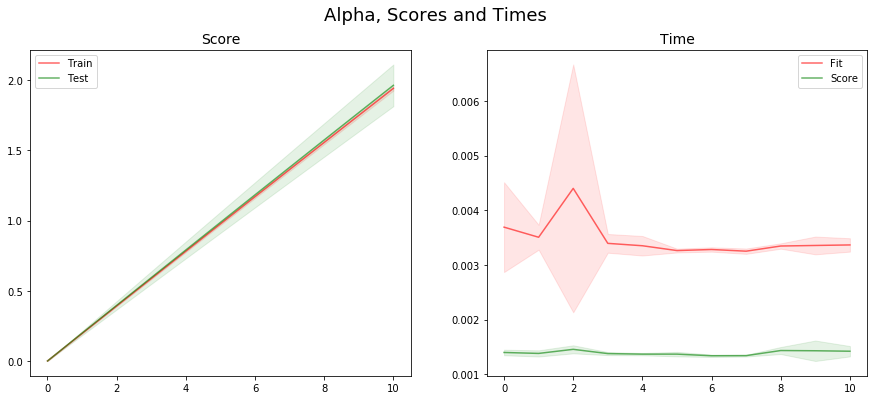

In [17]:
hyp.plot_hyperparameter(res[(res.param_ridge__solver=='svd') & (res.param_ridge__tol==0.001)], 'param_ridge__alpha', 'Alpha')

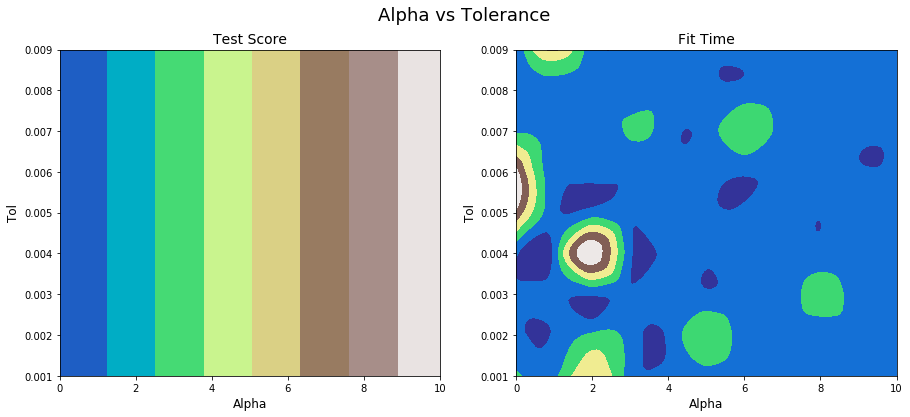

In [18]:
hyp.plot_two_hyperparms(res[(res.param_ridge__solver=='svd')], 'param_ridge__alpha', 'param_ridge__tol', 'Alpha vs Tolerance')

In [23]:
model = Pipeline([('imputer', df_p.df_imputer()), 
                  ('ridge', Ridge(random_state=325))])

param_grid = {'ridge__alpha': list(np.arange(0, 100, 10)), 
              'ridge__tol': np.arange(0.001, 0.01, 0.001), 
              'ridge__solver': ['svd', 'sparse_cg', 'lsqr', 'saga']}

res = grid_results(model, kfolds, param_grid, target_name='tar_nonlin_10', sample=1000)

res.head()

{'ridge__alpha': 30, 'ridge__solver': 'svd', 'ridge__tol': 0.001}


param_ridge__alpha param_ridge__solver param_ridge__tol  mean_train_score  \
0                 30                 svd            0.006        -12.285444   
1                 30                 svd            0.001        -12.285444   
2                 30                 svd            0.008        -12.285444   
3                 30                 svd            0.007        -12.285444   
4                 30                 svd            0.005        -12.285444   

   std_train_score  mean_test_score  std_test_score  mean_fit_time  \
0         0.174052       -13.739949        1.558744       0.013946   
1         0.174052       -13.739949        1.558744       0.012777   
2         0.174052       -13.739949        1.558744       0.013889   
3         0.174052       -13.739949        1.558744       0.016058   
4         0.174052       -13.739949        1.558744       0.014626   

   std_fit_time  mean_score_time  std_score_time  
0      0.000452         0.002034        0.000078  
1      0.000663         0.001909        0.000086  
2      0.001020         0.002061        0.000091  
3      0.001977         0.002614        0.000641  
4      0.002479         0.001970        0.000074

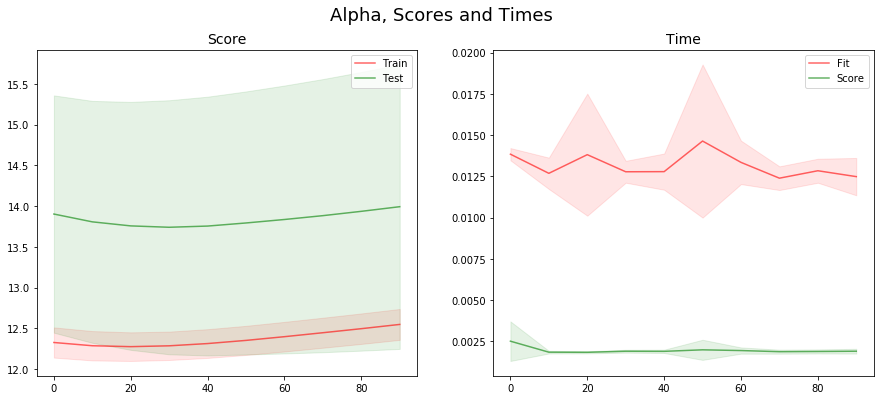

In [24]:
hyp.plot_hyperparameter(res[(res.param_ridge__solver=='svd') & (res.param_ridge__tol==0.001)], 'param_ridge__alpha', 'Alpha', uncertainty=True)

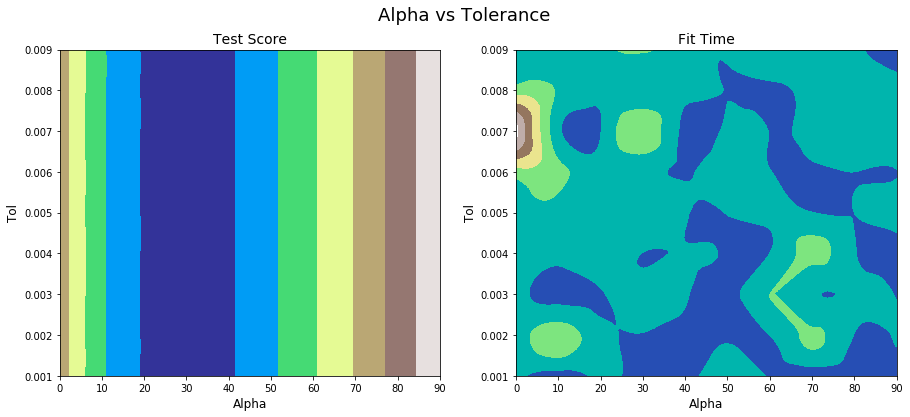

In [25]:
hyp.plot_two_hyperparms(res[(res.param_ridge__solver=='svd')], 'param_ridge__alpha', 'param_ridge__tol', 'Alpha vs Tolerance')

# Real application - HousePrice

In [26]:
model = ('ridge', Ridge())
params = {'alpa':1}

param_grid = {'ridge__alpha': np.arange(1, 42, 5),  
              'ridge__tol': np.arange(0.001, 0.01, 0.001),
              'ridge__solver': ['svd', 'sparse_cg', 'lsqr', 'saga']}

res = grid_results(model, kfolds, param_grid, hp=True)

res.head()

/home/lucabasa/Git/ML-algorithms-and-experiments/MLalgo/lib/python3.6/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


{'ridge__alpha': 11, 'ridge__solver': 'svd', 'ridge__tol': 0.001}


param_ridge__alpha param_ridge__solver param_ridge__tol  mean_train_score  \
0                 11                 svd            0.008         -0.080595   
1                 11                 svd            0.001         -0.080595   
2                 11                 svd            0.007         -0.080595   
3                 11                 svd            0.006         -0.080595   
4                 11                 svd            0.005         -0.080595   

   std_train_score  mean_test_score  std_test_score  mean_fit_time  \
0         0.000961        -0.084333        0.008003       0.169796   
1         0.000961        -0.084333        0.008003       0.170383   
2         0.000961        -0.084333        0.008003       0.168864   
3         0.000961        -0.084333        0.008003       0.170557   
4         0.000961        -0.084333        0.008003       0.169402   

   std_fit_time  mean_score_time  std_score_time  
0      0.004285         0.100799        0.001961  
1      0.005247         0.102066        0.004348  
2      0.003417         0.099814        0.001441  
3      0.003458         0.101234        0.003165  
4      0.003426         0.100294        0.001987

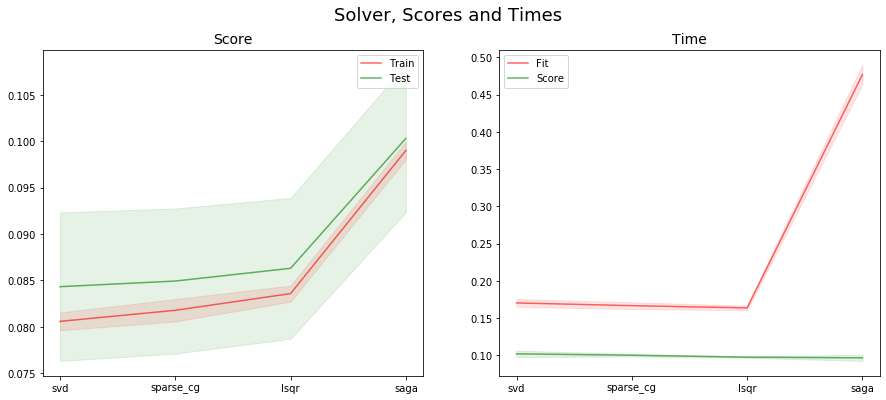

In [27]:
hyp.plot_hyperparameter(res[(res.param_ridge__alpha == 11) & (res.param_ridge__tol==0.001)], 'param_ridge__solver', 'Solver')

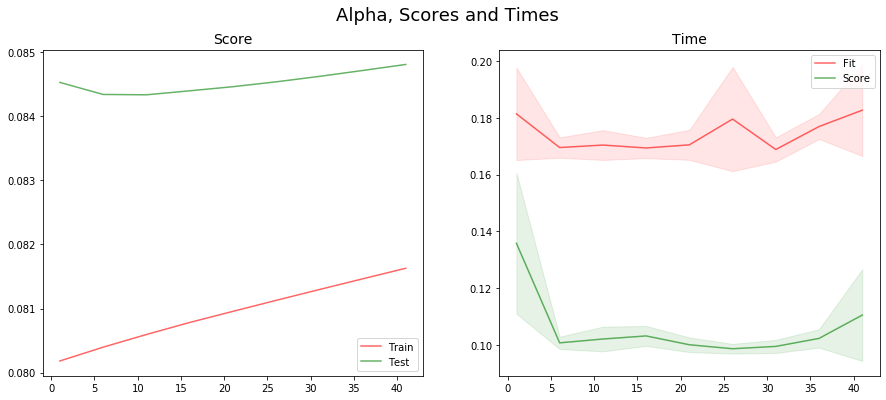

In [30]:
hyp.plot_hyperparameter(res[(res.param_ridge__solver=='svd') & (res.param_ridge__tol==0.001)], 
                        'param_ridge__alpha', 'Alpha', uncertainty=False)

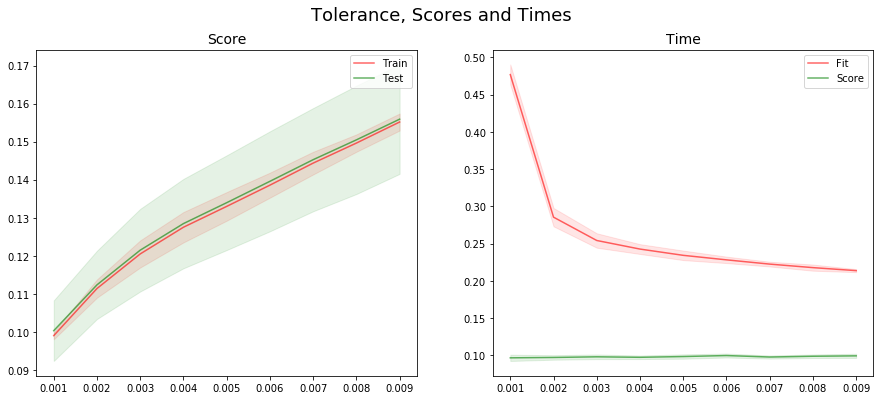

In [31]:
hyp.plot_hyperparameter(res[(res.param_ridge__solver=='saga') & (res.param_ridge__alpha==11)], 
                        'param_ridge__tol', 'Tolerance', uncertainty=True)

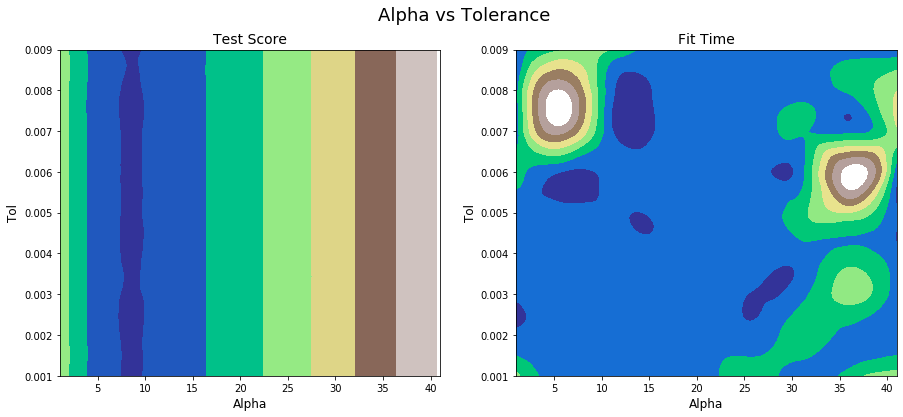

In [32]:
hyp.plot_two_hyperparms(res[(res.param_ridge__solver=='svd')], 'param_ridge__alpha', 'param_ridge__tol', 'Alpha vs Tolerance')

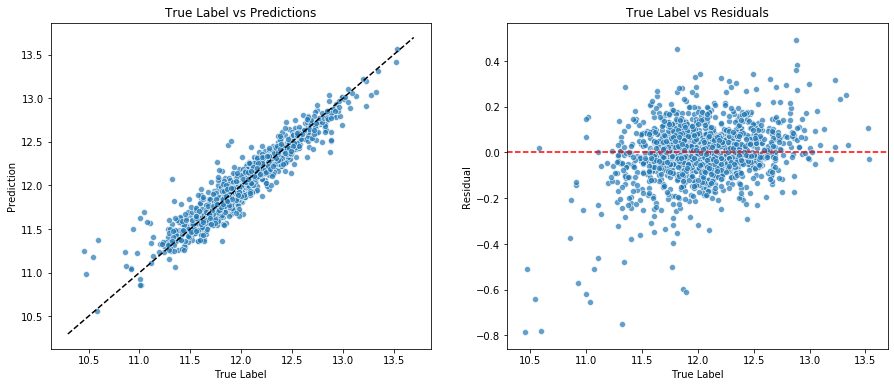

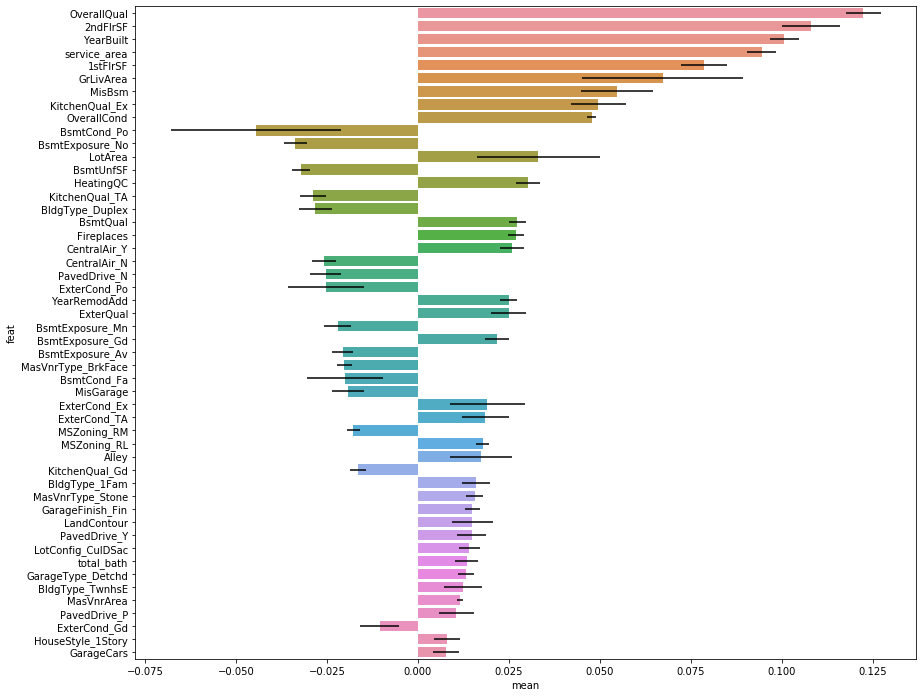

MAE: 		 0.08452
MSE: 		 0.01488
Max Error: 	 0.78325
Expl Variance: 	 0.90681


In [17]:
model = ('ridge', Ridge())
params = {'alpa':1}

make_exp(model=model, kfolds=kfolds, 
         hp=True,
         store=True, store_name=lab_book, 
         parameters=params, model_name='Ridge')

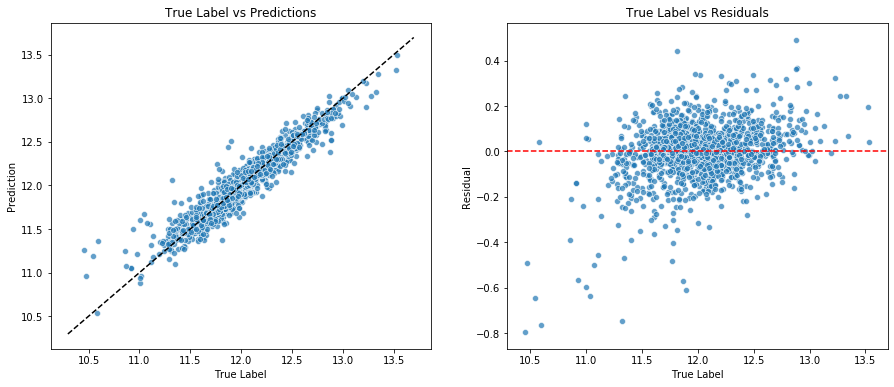

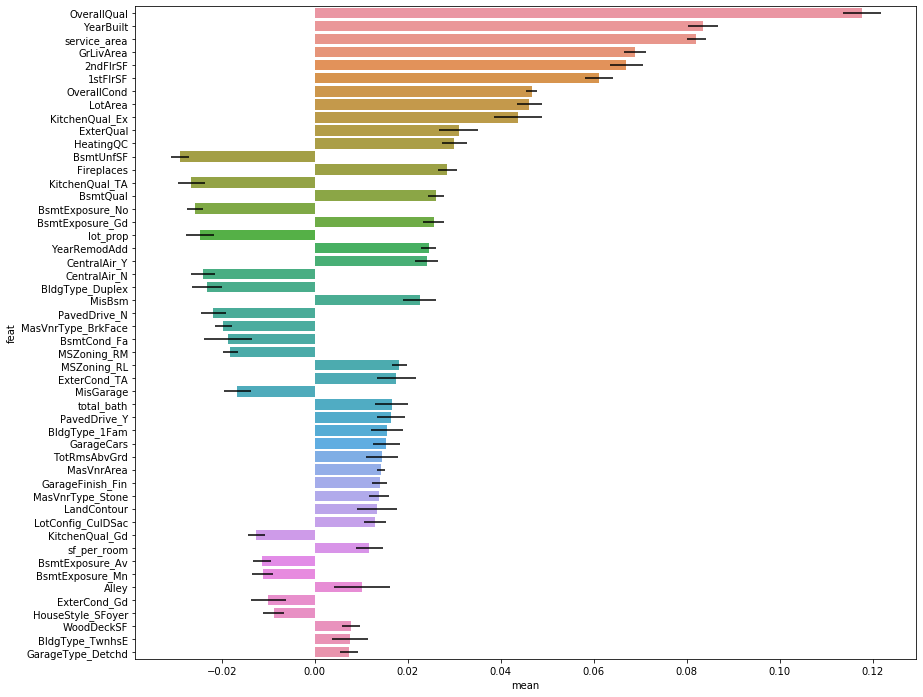

MAE: 		 0.08445
MSE: 		 0.01471
Max Error: 	 0.79443
Expl Variance: 	 0.90787


In [18]:
model = ('ridge', Ridge(alpha=21))
params = {'alpa':11}

make_exp(model=model, kfolds=kfolds, 
         hp=True,
         store=True, store_name=lab_book, 
         parameters=params, model_name='Ridge')

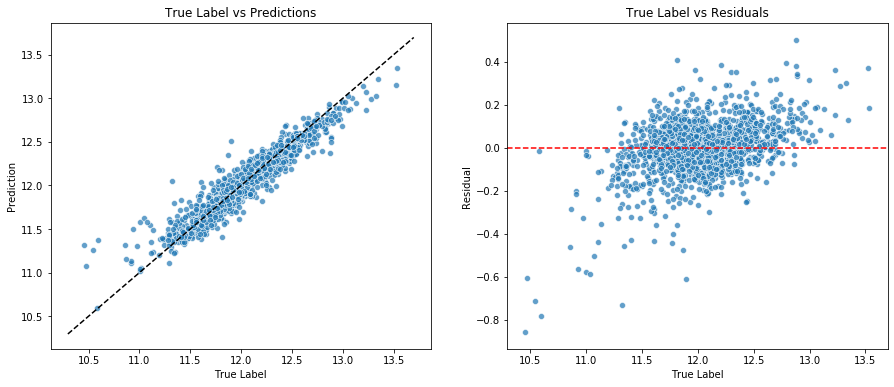

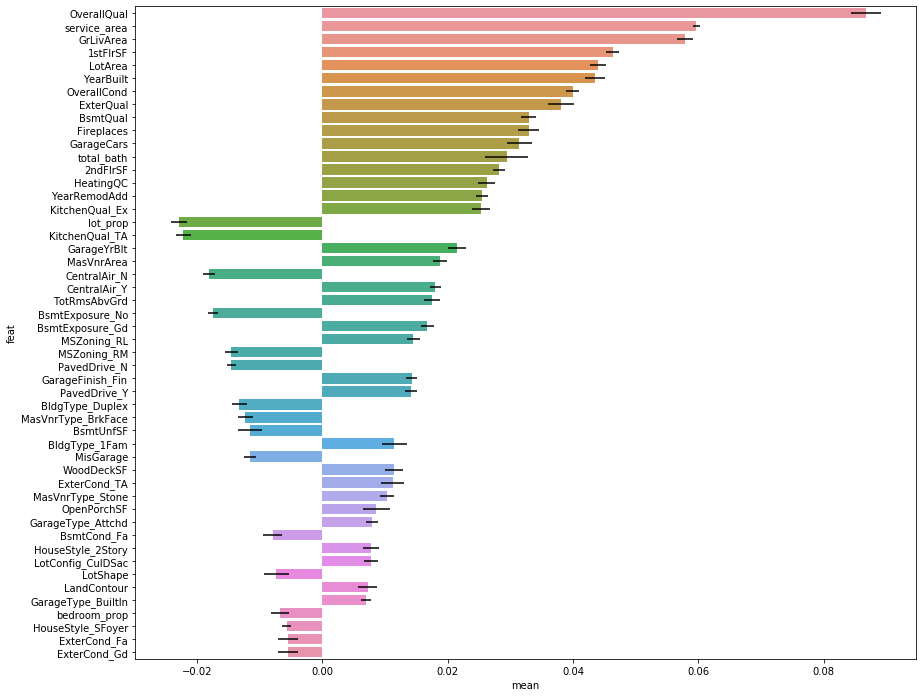

MAE: 		 0.08872
MSE: 		 0.0159
Max Error: 	 0.85645
Expl Variance: 	 0.90038


In [51]:
model = ('ridge', Ridge(alpha=200))
params = {'alpa':200}

make_exp(model=model, kfolds=kfolds, 
         hp=True,
         store=True, store_name=lab_book, 
         parameters=params, model_name='Ridge')

# Conclusion